Download Images and Prepare Data

In [12]:
import pandas as pd
import requests
import os

import yolov5
from tqdm.notebook import tqdm

# Load image URLs from CSV 
image_urls = pd.read_csv('all_image_urls.csv', header=None)

# Display the first rows
print(image_urls.head())

# Create directory for images
os.makedirs('yolov5/data/images/all', exist_ok=True)

# download images
def download_images(image_urls):
    all_urls = pd.concat([image_urls[0], image_urls[1]]).dropna()  
    for url in tqdm(all_urls):
        image_name = url.split('/')[-1]
        image_path = os.path.join('yolov5/data/images/all', image_name)
        response = requests.get(url)
        with open(image_path, 'wb') as f:
            f.write(response.content)


download_images(image_urls)


                                                   0  \
0  https://farm66.staticflickr.com/65535/33978196...   
1  https://farm66.staticflickr.com/65535/47803331...   
2  https://farm66.staticflickr.com/65535/40888872...   
3  https://farm66.staticflickr.com/65535/47803331...   
4  https://farm66.staticflickr.com/65535/33978199...   

                                                   1  
0  https://farm66.staticflickr.com/65535/33978196...  
1  https://farm66.staticflickr.com/65535/47803331...  
2  https://farm66.staticflickr.com/65535/40888872...  
3  https://farm66.staticflickr.com/65535/47803331...  
4  https://farm66.staticflickr.com/65535/33978199...  


  0%|          | 0/7333 [00:00<?, ?it/s]

Convert Annotations and Split Data

In [11]:
import json
import shutil
import os
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Load annotations
with open('annotations.json') as f:
    annotations = json.load(f)

# Create directories for YOLO format
os.makedirs('yolov5/data/images/train', exist_ok=True)
os.makedirs('yolov5/data/images/val', exist_ok=True)
os.makedirs('yolov5/data/images/test', exist_ok=True)
os.makedirs('yolov5/data/labels/train', exist_ok=True)
os.makedirs('yolov5/data/labels/val', exist_ok=True)
os.makedirs('yolov5/data/labels/test', exist_ok=True)

# Function to convert COCO to YOLO format
def convert_to_yolo(annotation):
    image_id = annotation['image_id']
    image_info = next(image for image in annotations['images'] if image['id'] == image_id)
    width, height = image_info['width'], image_info['height']
    
    x_min = annotation['bbox'][0]
    y_min = annotation['bbox'][1]
    box_width = annotation['bbox'][2]
    box_height = annotation['bbox'][3]
    
    x_center = x_min + box_width / 2
    y_center = y_min + box_height / 2
    
    x_center /= width
    y_center /= height
    box_width /= width
    box_height /= height
    
    return f"{annotation['category_id']} {x_center} {y_center} {box_width} {box_height}"

# Split data
image_ids = [img['id'] for img in annotations['images']]
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

# Get filenames in directory
actual_filenames = os.listdir('yolov5/data/images/all')

# Function to find actual filename from the URL
def get_actual_filename(url):
    for filename in actual_filenames:
        if filename in url:
            return filename
    return None

# Function to save images and labels
def save_data(split, ids):
    for img_id in ids:
        image_info = next(image for image in annotations['images'] if image['id'] == img_id)
        image_filename = get_actual_filename(image_info['flickr_url'])
        
        if image_filename is None:
            print(f"Image file not found for URL: {image_info['flickr_url']}")
            continue
        
        image_path = f"yolov5/data/images/all/{image_filename}"
        target_image_path = f"yolov5/data/images/{split}/{image_filename}"
        label_path = f"yolov5/data/labels/{split}/{os.path.splitext(image_filename)[0]}.txt"
        
        # Copy image
        shutil.copy(image_path, target_image_path)
        
        # Save label
        labels = [convert_to_yolo(ann) for ann in annotations['annotations'] if ann['image_id'] == img_id]
        with open(label_path, 'w') as f:
            f.write('\n'.join(labels))

save_data('train', train_ids)
save_data('val', val_ids)
save_data('test', test_ids)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'yolov5/data/images/all'

Verification of labels

In [8]:
import os

# Function to count files
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Function to print
def verify_dataset(image_dir, label_dir):
    image_count = count_files(image_dir)
    label_count = count_files(label_dir)
    print(f"Directory: {image_dir}")
    print(f"Number of images: {image_count}")
    print(f"Number of labels: {label_count}")
    if image_count == label_count:
        print("Counts match")
    else:
        print("Counts do not match")
    print()

# Directories to verify
splits = ['train', 'val', 'test']

for split in splits:
    image_dir = f"yolov5/data/images/{split}"
    label_dir = f"yolov5/data/labels/{split}"
    verify_dataset(image_dir, label_dir)


Directory: yolov5/data/images/train
Number of images: 1080
Number of labels: 1080
Counts match

Directory: yolov5/data/images/val
Number of images: 120
Number of labels: 120
Counts match

Directory: yolov5/data/images/test
Number of images: 300
Number of labels: 300
Counts match



Detailed logging of annotations:

In [9]:
import json
import shutil
import os
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Load annotations
with open('annotations.json') as f:
    annotations = json.load(f)

# Create directories for YOLO format
os.makedirs('yolov5/data/images/train', exist_ok=True)
os.makedirs('yolov5/data/images/val', exist_ok=True)
os.makedirs('yolov5/data/images/test', exist_ok=True)
os.makedirs('yolov5/data/labels/train', exist_ok=True)
os.makedirs('yolov5/data/labels/val', exist_ok=True)
os.makedirs('yolov5/data/labels/test', exist_ok=True)

# Function to convert COCO to YOLO format
def convert_to_yolo(annotation):
    image_id = annotation['image_id']
    image_info = next(image for image in annotations['images'] if image['id'] == image_id)
    width, height = image_info['width'], image_info['height']
    
    x_min = annotation['bbox'][0]
    y_min = annotation['bbox'][1]
    box_width = annotation['bbox'][2]
    box_height = annotation['bbox'][3]
    
    x_center = x_min + box_width / 2
    y_center = y_min + box_height / 2
    
    x_center /= width
    y_center /= height
    box_width /= width
    box_height /= height
    
    return f"{annotation['category_id']} {x_center} {y_center} {box_width} {box_height}"

# Split data
image_ids = [img['id'] for img in annotations['images']]
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

# Get actual filenames 
actual_filenames = os.listdir('yolov5/data/images/all')

# Function to find filename in URL
def get_actual_filename(url):
    for filename in actual_filenames:
        if filename in url:
            return filename
    return None

# Function to save images labels 
def save_data(split, ids):
    not_found_images = []
    processed_images = 0

    for img_id in ids:
        image_info = next(image for image in annotations['images'] if image['id'] == img_id)
        image_filename = get_actual_filename(image_info['flickr_url'])
        
        if image_filename is None:
            not_found_images.append(image_info['flickr_url'])
            continue
        
        image_path = f"yolov5/data/images/all/{image_filename}"
        target_image_path = f"yolov5/data/images/{split}/{image_filename}"
        label_path = f"yolov5/data/labels/{split}/{os.path.splitext(image_filename)[0]}.txt"
        
        # Copy image
        shutil.copy(image_path, target_image_path)
        processed_images += 1
        
        # Save label
        labels = [convert_to_yolo(ann) for ann in annotations['annotations'] if ann['image_id'] == img_id]
        with open(label_path, 'w') as f:
            f.write('\n'.join(labels))
    
    print(f"Processed {processed_images} images for {split} set.")
    print(f"Could not find {len(not_found_images)} images for {split} set.")
    if not_found_images:
        with open(f"not_found_{split}.txt", 'w') as f:
            for item in not_found_images:
                f.write(f"{item}\n")

save_data('train', train_ids)
save_data('val', val_ids)
save_data('test', test_ids)


Processed 1080 images for train set.
Could not find 0 images for train set.
Processed 120 images for val set.
Could not find 0 images for val set.
Processed 300 images for test set.
Could not find 0 images for test set.


Missing annotations noticed test for amount in annotations

In [10]:
import json
import os

# Load annotations
with open('annotations.json') as f:
    annotations = json.load(f)

# Get filenames
actual_filenames = set(os.listdir('yolov5/data/images/all'))

# Get filenames from annotations
annotated_filenames = set()

for image_info in annotations['images']:
    # Extract filename from the flickr_url in annotations
    flickr_url = image_info['flickr_url']
    filename = flickr_url.split('/')[-1]
    annotated_filenames.add(filename)

# Find images in directory not referenced in annotations
not_referenced_images = actual_filenames - annotated_filenames

# Find images referenced in annotations but not in directory
missing_images = annotated_filenames - actual_filenames

# Print summary
print(f"Total images in directory: {len(actual_filenames)}")
print(f"Total images in annotations: {len(annotated_filenames)}")
print(f"Images not referenced in annotations: {len(not_referenced_images)}")
print(f"Images referenced in annotations but not found in directory: {len(missing_images)}")

if not_referenced_images:
    with open('not_referenced_images.txt', 'w') as f:
        for item in not_referenced_images:
            f.write(f"{item}\n")
            
if missing_images:
    with open('missing_images.txt', 'w') as f:
        for item in missing_images:
            f.write(f"{item}\n")


Total images in directory: 7328
Total images in annotations: 1500
Images not referenced in annotations: 5828
Images referenced in annotations but not found in directory: 0


Missing annotations noticed test for amount in unooficial_annotations

In [11]:
import json
import os

# Load unofficial annotations
with open('annotations_unofficial.json') as f:
    annotations = json.load(f)

# Get actual filenames in the directory
actual_filenames = set(os.listdir('yolov5/data/images/all'))

# Get filenames from unofficial annotations
annotated_filenames = set()

for image_info in annotations['images']:
    # Extract filename from the flickr_url in annotations
    flickr_url = image_info['flickr_url']
    filename = flickr_url.split('/')[-1]
    annotated_filenames.add(filename)

# Find images in directory not referenced in annotations
not_referenced_images = actual_filenames - annotated_filenames

# Find images referenced in annotations but not in directory
missing_images = annotated_filenames - actual_filenames

# Print summary
print(f"Total images in directory: {len(actual_filenames)}")
print(f"Total images in annotations: {len(annotated_filenames)}")
print(f"Images not referenced in annotations: {len(not_referenced_images)}")
print(f"Images referenced in annotations but not found in directory: {len(missing_images)}")

if not_referenced_images:
    with open('not_referenced_images.txt', 'w') as f:
        for item in not_referenced_images:
            f.write(f"{item}\n")
            
if missing_images:
    with open('missing_images.txt', 'w') as f:
        for item in missing_images:
            f.write(f"{item}\n")


Total images in directory: 7328
Total images in annotations: 3831
Images not referenced in annotations: 4215
Images referenced in annotations but not found in directory: 718


Going forward two annotations will be tested 

Official annotation:

In [13]:
import json
import shutil
import os
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Load official annotations
with open('annotations.json') as f:
    annotations = json.load(f)

# Create directories for YOLO format
os.makedirs('yolov5/data_official/images/train', exist_ok=True)
os.makedirs('yolov5/data_official/images/val', exist_ok=True)
os.makedirs('yolov5/data_official/images/test', exist_ok=True)
os.makedirs('yolov5/data_official/labels/train', exist_ok=True)
os.makedirs('yolov5/data_official/labels/val', exist_ok=True)
os.makedirs('yolov5/data_official/labels/test', exist_ok=True)

# Function to convert COCO to YOLO format
def convert_to_yolo(annotation):
    image_id = annotation['image_id']
    image_info = next(image for image in annotations['images'] if image['id'] == image_id)
    width, height = image_info['width'], image_info['height']
    
    x_min = annotation['bbox'][0]
    y_min = annotation['bbox'][1]
    box_width = annotation['bbox'][2]
    box_height = annotation['bbox'][3]
    
    x_center = x_min + box_width / 2
    y_center = y_min + box_height / 2
    
    x_center /= width
    y_center /= height
    box_width /= width
    box_height /= height
    
    return f"{annotation['category_id']} {x_center} {y_center} {box_width} {box_height}"

# Split data
image_ids = [img['id'] for img in annotations['images']]
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

# Get actual filenames 
actual_filenames = os.listdir('yolov5/data/images/all')

# Function to find actual filename from the URL
def get_actual_filename(url):
    for filename in actual_filenames:
        if filename in url:
            return filename
    return None

# Function to save images and labels
def save_data(split, ids, base_path):
    for img_id in ids:
        image_info = next(image for image in annotations['images'] if image['id'] == img_id)
        image_filename = get_actual_filename(image_info['flickr_url'])
        
        if image_filename is None:
            print(f"Image file not found for URL: {image_info['flickr_url']}")
            continue
        
        image_path = f"yolov5/data/images/all/{image_filename}"
        target_image_path = f"{base_path}/images/{split}/{image_filename}"
        label_path = f"{base_path}/labels/{split}/{os.path.splitext(image_filename)[0]}.txt"
        
        # Copy image
        shutil.copy(image_path, target_image_path)
        
        # Save label
        labels = [convert_to_yolo(ann) for ann in annotations['annotations'] if ann['image_id'] == img_id]
        with open(label_path, 'w') as f:
            f.write('\n'.join(labels))

save_data('train', train_ids, 'yolov5/data_official')
save_data('val', val_ids, 'yolov5/data_official')
save_data('test', test_ids, 'yolov5/data_official')


UnOfficial annotation:

In [70]:
import json
import shutil
import os
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
%cd C:\Users\Nicho\Desktop\Thesis\yodataco

# Load unofficial annotations
with open('annotations_unofficial.json') as f:
    annotations = json.load(f)

# Create directories for YOLO format
os.makedirs('yolov5/data_unofficial/images/train', exist_ok=True)
os.makedirs('yolov5/data_unofficial/images/val', exist_ok=True)
os.makedirs('yolov5/data_unofficial/images/test', exist_ok=True)
os.makedirs('yolov5/data_unofficial/labels/train', exist_ok=True)
os.makedirs('yolov5/data_unofficial/labels/val', exist_ok=True)
os.makedirs('yolov5/data_unofficial/labels/test', exist_ok=True)

# Function to convert COCO to YOLO format
def convert_to_yolo(annotation):
    image_id = annotation['image_id']
    image_info = next(image for image in annotations['images'] if image['id'] == image_id)
    width, height = image_info['width'], image_info['height']
    
    x_min = annotation['bbox'][0]
    y_min = annotation['bbox'][1]
    box_width = annotation['bbox'][2]
    box_height = annotation['bbox'][3]
    
    x_center = x_min + box_width / 2
    y_center = y_min + box_height / 2
    
    x_center /= width
    y_center /= height
    box_width /= width
    box_height /= height
    
    return f"{annotation['category_id']} {x_center} {y_center} {box_width} {box_height}"

# Split data
image_ids = [img['id'] for img in annotations['images']]
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

# Get actual filenames in the directory
actual_filenames = os.listdir('yolov5/data/images/all')

# Function to find actual filename from the URL
def get_actual_filename(url):
    for filename in actual_filenames:
        if filename in url:
            return filename
    return None

# Function to save images and labels
def save_data(split, ids, base_path):
    for img_id in ids:
        image_info = next(image for image in annotations['images'] if image['id'] == img_id)
        image_filename = get_actual_filename(image_info['flickr_url'])
        
        if image_filename is None:
            print(f"Image file not found for URL: {image_info['flickr_url']}")
            continue
        
        image_path = f"yolov5/data/images/all/{image_filename}"
        target_image_path = f"{base_path}/images/{split}/{image_filename}"
        label_path = f"{base_path}/labels/{split}/{os.path.splitext(image_filename)[0]}.txt"
        
        # Copy image
        shutil.copy(image_path, target_image_path)
        
        # Save label
        labels = [convert_to_yolo(ann) for ann in annotations['annotations'] if ann['image_id'] == img_id]
        with open(label_path, 'w') as f:
            f.write('\n'.join(labels))

save_data('train', train_ids, 'yolov5/data_unofficial')
save_data('val', val_ids, 'yolov5/data_unofficial')
save_data('test', test_ids, 'yolov5/data_unofficial')


C:\Users\Nicho\Desktop\Thesis\yodataco
Image file not found for URL: https://farm66.staticflickr.com/65535/50833353463_6fbd0d01f0_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/50834137281_8355968eef_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/50833281798_ed4f5291cb_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/51620044709_52274e5c38_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/51620125060_f97ed7b5a5_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/51620119515_9b49114355_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/50834123626_30413185bb_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/50833282128_b9eea69f65_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/51619898709_28365df6c6_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/52223782422_ac3cc259

Check for classes in annotations

In [35]:
import json
import os

annotations_path = os.path.join('..', 'annotations.json')

# Load annotations
with open(annotations_path) as f:
    annotations = json.load(f)

# Extract unique class IDs
class_ids = set()

for annotation in annotations['annotations']:
    class_ids.add(annotation['category_id'])

# Print the number of unique classes
print(f"Number of unique classes: {len(class_ids)}")
print(f"Class IDs: {sorted(list(class_ids))}")

# Optionally, map class IDs to class names if available in the annotations
if 'categories' in annotations:
    class_id_to_name = {category['id']: category['name'] for category in annotations['categories']}
    print("Class ID to Class Name Mapping:")
    for class_id in sorted(list(class_ids)):
        print(f"ID: {class_id}, Name: {class_id_to_name.get(class_id, 'Unknown')}")
else:
    print("No class names found in the annotations.")


Number of unique classes: 59
Class IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Class ID to Class Name Mapping:
ID: 0, Name: Aluminium foil
ID: 1, Name: Battery
ID: 2, Name: Aluminium blister pack
ID: 3, Name: Carded blister pack
ID: 4, Name: Other plastic bottle
ID: 5, Name: Clear plastic bottle
ID: 6, Name: Glass bottle
ID: 7, Name: Plastic bottle cap
ID: 8, Name: Metal bottle cap
ID: 9, Name: Broken glass
ID: 10, Name: Food Can
ID: 11, Name: Aerosol
ID: 12, Name: Drink can
ID: 13, Name: Toilet tube
ID: 14, Name: Other carton
ID: 15, Name: Egg carton
ID: 16, Name: Drink carton
ID: 17, Name: Corrugated carton
ID: 18, Name: Meal carton
ID: 19, Name: Pizza box
ID: 20, Name: Paper cup
ID: 21, Name: Disposable plastic cup
ID: 22, Name: Foam cup
ID: 23, Name: Glass cup
ID: 24, Name: Other plastic cup
ID: 2

Check for classes in unofficial annotations

In [71]:
import json

# Load unofficial annotations
with open('annotations_unofficial.json') as f:
    annotations = json.load(f)

# Extract unique class IDs
class_ids = set()

for annotation in annotations['annotations']:
    class_ids.add(annotation['category_id'])

# Print the number of unique classes
print(f"Number of unique classes: {len(class_ids)}")
print(f"Class IDs: {sorted(list(class_ids))}")

# Optionally, map class IDs to class names if available in the annotations
if 'categories' in annotations:
    class_id_to_name = {category['id']: category['name'] for category in annotations['categories']}
    print("Class ID to Class Name Mapping:")
    for class_id in sorted(list(class_ids)):
        print(f"ID: {class_id}, Name: {class_id_to_name.get(class_id, 'Unknown')}")
else:
    print("No class names found in the annotations.")


Number of unique classes: 60
Class IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Class ID to Class Name Mapping:
ID: 0, Name: Aluminium foil
ID: 1, Name: Battery
ID: 2, Name: Aluminium blister pack
ID: 3, Name: Carded blister pack
ID: 4, Name: Other plastic bottle
ID: 5, Name: Clear plastic bottle
ID: 6, Name: Glass bottle
ID: 7, Name: Plastic bottle cap
ID: 8, Name: Metal bottle cap
ID: 9, Name: Broken glass
ID: 10, Name: Food Can
ID: 11, Name: Aerosol
ID: 12, Name: Drink can
ID: 13, Name: Toilet tube
ID: 14, Name: Other carton
ID: 15, Name: Egg carton
ID: 16, Name: Drink carton
ID: 17, Name: Corrugated carton
ID: 18, Name: Meal carton
ID: 19, Name: Pizza box
ID: 20, Name: Paper cup
ID: 21, Name: Disposable plastic cup
ID: 22, Name: Foam cup
ID: 23, Name: Glass cup
ID: 24, Name: Other plastic cup
I

data_official.yaml

In [14]:
import os

# Ensure we are in the yolov5 directory
%cd yolov5

# YAML content for the official dataset
official_yaml = """train: yolov5/data_official/images/train
val: yolov5/data_official/images/val
test: yolov5/data_official/images/test

nc: 59
names: [
  "Aluminium foil", "Battery", "Aluminium blister pack", "Carded blister pack", 
  "Other plastic bottle", "Clear plastic bottle", "Glass bottle", "Plastic bottle cap", 
  "Metal bottle cap", "Broken glass", "Food Can", "Aerosol", "Drink can", "Toilet tube", 
  "Other carton", "Egg carton", "Drink carton", "Corrugated carton", "Meal carton", 
  "Pizza box", "Paper cup", "Disposable plastic cup", "Foam cup", "Glass cup", 
  "Other plastic cup", "Food waste", "Glass jar", "Plastic lid", "Metal lid", 
  "Other plastic", "Magazine paper", "Tissues", "Wrapping paper", "Normal paper", 
  "Paper bag", "Plastic film", "Six pack rings", "Garbage bag", "Other plastic wrapper", 
  "Single-use carrier bag", "Polypropylene bag", "Crisp packet", "Spread tub", 
  "Tupperware", "Disposable food container", "Foam food container", 
  "Other plastic container", "Plastic gloves", "Plastic utensils", "Pop tab", 
  "Rope & strings", "Scrap metal", "Shoe", "Squeezable tube", "Plastic straw", 
  "Paper straw", "Styrofoam piece", "Unlabeled litter", "Cigarette"
]
"""

# Write the content to data_official.yaml
with open('data_official.yaml', 'w') as f:
    f.write(official_yaml)

# Verify the file content
with open('data_official.yaml', 'r') as f:
    content = f.read()
    print(content)


C:\Users\Nicho\Desktop\Thesis\yodataco\yolov5
train: yolov5/data_official/images/train
val: yolov5/data_official/images/val
test: yolov5/data_official/images/test

nc: 59
names: [
  "Aluminium foil", "Battery", "Aluminium blister pack", "Carded blister pack", 
  "Other plastic bottle", "Clear plastic bottle", "Glass bottle", "Plastic bottle cap", 
  "Metal bottle cap", "Broken glass", "Food Can", "Aerosol", "Drink can", "Toilet tube", 
  "Other carton", "Egg carton", "Drink carton", "Corrugated carton", "Meal carton", 
  "Pizza box", "Paper cup", "Disposable plastic cup", "Foam cup", "Glass cup", 
  "Other plastic cup", "Food waste", "Glass jar", "Plastic lid", "Metal lid", 
  "Other plastic", "Magazine paper", "Tissues", "Wrapping paper", "Normal paper", 
  "Paper bag", "Plastic film", "Six pack rings", "Garbage bag", "Other plastic wrapper", 
  "Single-use carrier bag", "Polypropylene bag", "Crisp packet", "Spread tub", 
  "Tupperware", "Disposable food container", "Foam food contain

data_unofficial.yaml

In [23]:
# YAML content for the unofficial dataset
unofficial_yaml = """train: yolov5/data_unofficial/images/train
val: yolov5/data_unofficial/images/val
test: yolov5/data_unofficial/images/test

nc: 60
names: [
  "Aluminium foil", "Battery", "Aluminium blister pack", "Carded blister pack", 
  "Other plastic bottle", "Clear plastic bottle", "Glass bottle", "Plastic bottle cap", 
  "Metal bottle cap", "Broken glass", "Food Can", "Aerosol", "Drink can", "Toilet tube", 
  "Other carton", "Egg carton", "Drink carton", "Corrugated carton", "Meal carton", 
  "Pizza box", "Paper cup", "Disposable plastic cup", "Foam cup", "Glass cup", 
  "Other plastic cup", "Food waste", "Glass jar", "Plastic lid", "Metal lid", 
  "Other plastic", "Magazine paper", "Tissues", "Wrapping paper", "Normal paper", 
  "Paper bag", "Plastified paper bag", "Plastic film", "Six pack rings", 
  "Garbage bag", "Other plastic wrapper", "Single-use carrier bag", "Polypropylene bag", 
  "Crisp packet", "Spread tub", "Tupperware", "Disposable food container", 
  "Foam food container", "Other plastic container", "Plastic gloves", 
  "Plastic utensils", "Pop tab", "Rope & strings", "Scrap metal", "Shoe", 
  "Squeezable tube", "Plastic straw", "Paper straw", "Styrofoam piece", 
  "Unlabeled litter", "Cigarette"
]
"""

# Write the content to data_unofficial.yaml
with open('data_unofficial.yaml', 'w') as f:
    f.write(unofficial_yaml)

# Verify the file content
with open('data_unofficial.yaml', 'r') as f:
    content = f.read()
    print(content)


train: yolov5/data_unofficial/images/train
val: yolov5/data_unofficial/images/val
test: yolov5/data_unofficial/images/test

nc: 60
names: [
  "Aluminium foil", "Battery", "Aluminium blister pack", "Carded blister pack", 
  "Other plastic bottle", "Clear plastic bottle", "Glass bottle", "Plastic bottle cap", 
  "Metal bottle cap", "Broken glass", "Food Can", "Aerosol", "Drink can", "Toilet tube", 
  "Other carton", "Egg carton", "Drink carton", "Corrugated carton", "Meal carton", 
  "Pizza box", "Paper cup", "Disposable plastic cup", "Foam cup", "Glass cup", 
  "Other plastic cup", "Food waste", "Glass jar", "Plastic lid", "Metal lid", 
  "Other plastic", "Magazine paper", "Tissues", "Wrapping paper", "Normal paper", 
  "Paper bag", "Plastified paper bag", "Plastic film", "Six pack rings", 
  "Garbage bag", "Other plastic wrapper", "Single-use carrier bag", "Polypropylene bag", 
  "Crisp packet", "Spread tub", "Tupperware", "Disposable food container", 
  "Foam food container", "Other p

Train the officlal Model

In [36]:
# Ensure in the yolov5 directory
%cd yolov5

# Train model with official annotations
!python train.py --img 640 --batch 16 --epochs 10 --data data_official.yaml --weights yolov5s.pt --project official_yolo


[WinError 2] The system cannot find the file specified: 'yolov5'
C:\Users\Nicho\Desktop\Thesis\yodataco\yolov5
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: weights=yolov5s.pt, cfg=, data=data_official.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=official_yolo, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
YOLOv5  2024-6-2 Python-3.11.9 torch-2.3.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, d

In [37]:
import json

# Load annotations
annotations_path = os.path.join('..', 'annotations.json')
with open(annotations_path) as f:
    annotations = json.load(f)

# Extract unique class IDs
class_ids = set()
for annotation in annotations['annotations']:
    class_ids.add(annotation['category_id'])

# Print the number of unique classes
print(f"Number of unique classes: {len(class_ids)}")
print(f"Class IDs: {sorted(list(class_ids))}")

# Check for class IDs outside the expected range
invalid_class_ids = [class_id for class_id in class_ids if class_id >= 59]
if invalid_class_ids:
    print(f"Invalid class IDs found: {invalid_class_ids}")
else:
    print("All class IDs are within the expected range.")


Number of unique classes: 59
Class IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Invalid class IDs found: [59]


In [38]:
import json
import os

# Load annotations
annotations_path = os.path.join('..', 'annotations.json')
with open(annotations_path) as f:
    annotations = json.load(f)

# Remove annotations with invalid class ID 59
valid_class_ids = set(range(59))
corrected_annotations = [
    annotation for annotation in annotations['annotations']
    if annotation['category_id'] in valid_class_ids
]

# Print the number of removed annotations
removed_annotations_count = len(annotations['annotations']) - len(corrected_annotations)
print(f"Removed {removed_annotations_count} annotations with invalid class ID 59.")

# Update the annotations dictionary
annotations['annotations'] = corrected_annotations

# Save corrected annotations
corrected_annotations_path = os.path.join('..', 'corrected_annotations.json')
with open(corrected_annotations_path, 'w') as f:
    json.dump(annotations, f)

print("Annotations have been corrected and saved.")


Removed 667 annotations with invalid class ID 59.
Annotations have been corrected and saved.


In [15]:
import json
import os

# Load corrected annotations
annotations_path = os.path.join('..', 'corrected_annotations.json')
with open(annotations_path) as f:
    annotations = json.load(f)

# Extract unique class IDs
class_ids = set()
for annotation in annotations['annotations']:
    class_ids.add(annotation['category_id'])

# Print the number of unique classes
print(f"Number of unique classes: {len(class_ids)}")
print(f"Class IDs: {sorted(list(class_ids))}")


Number of unique classes: 58
Class IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]


In [48]:
# Ensure in the yolov5 directory
%cd yolov5

# Train model with official annotations
!python train.py --img 640 --batch 16 --epochs 10 --data data_official.yaml --weights yolov5s.pt --project official_yolo


[WinError 2] The system cannot find the file specified: 'yolov5'
C:\Users\Nicho\Desktop\Thesis\yodataco\yolov5\yolov5


C:\Users\Nicho\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe: can't open file 'C:\\Users\\Nicho\\Desktop\\Thesis\\yodataco\\yolov5\\yolov5\\train.py': [Errno 2] No such file or directory


In [28]:
import json
import os
import yaml

%cd C:/Users/Nicho/Desktop/Thesis/yodataco

# Load the corrected annotations
annotations_path = os.path.join('yolov5', 'data_official', 'corrected_annotations.json')
with open(annotations_path) as f:
    annotations = json.load(f)

# Load data_official.yaml
yaml_path = os.path.join('yolov5', 'data_official', 'data_official.yaml')
with open(yaml_path) as f:
    data = yaml.safe_load(f)

# Verify and clean annotations
max_valid_class_id = len(data['names']) - 1
invalid_class_ids = {ann['category_id'] for ann in annotations['annotations'] if ann['category_id'] > max_valid_class_id}

if invalid_class_ids:
    print(f"Invalid class IDs found: {invalid_class_ids}")
    cleaned_annotations = [ann for ann in annotations['annotations'] if ann['category_id'] <= max_valid_class_id]
    
    # Save cleaned annotations
    with open(annotations_path, 'w') as f:
        json.dump({'annotations': cleaned_annotations, 'categories': annotations['categories']}, f)
    print(f"Removed annotations with invalid class IDs: {invalid_class_ids}")
else:
    print("No invalid class IDs found.")

# Final verification
class_ids = {ann['category_id'] for ann in annotations['annotations']}
print(f"Number of unique classes: {len(class_ids)}")
print(f"Class IDs: {sorted(list(class_ids))}")

# Verify that the number of classes and class names match data_official.yaml
num_classes = data['nc']
class_names = data['names']

if len(class_ids) != num_classes:
    print(f"Warning: Number of unique class IDs ({len(class_ids)}) does not match number of classes in YAML ({num_classes}).")

if set(class_ids) != set(range(num_classes)):
    print(f"Warning: Class IDs in annotations do not match class IDs in YAML. Annotations: {class_ids}, YAML: {set(range(num_classes))}")

print(f"Class names in YAML: {class_names}")


C:\Users\Nicho\Desktop\Thesis\yodataco
Invalid class IDs found: {57}
Removed annotations with invalid class IDs: {57}
Number of unique classes: 57
Class IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
Class names in YAML: ['Aluminium foil', 'Battery', 'Aluminium blister pack', 'Carded blister pack', 'Other plastic bottle', 'Clear plastic bottle', 'Glass bottle', 'Plastic bottle cap', 'Metal bottle cap', 'Broken glass', 'Food Can', 'Aerosol', 'Drink can', 'Toilet tube', 'Other carton', 'Egg carton', 'Drink carton', 'Corrugated carton', 'Meal carton', 'Pizza box', 'Paper cup', 'Disposable plastic cup', 'Foam cup', 'Glass cup', 'Other plastic cup', 'Food waste', 'Glass jar', 'Plastic lid', 'Metal lid', 'Other plastic', 'Magazine paper', 'Tissues', 'Wrapping paper', 'Normal paper', 'Paper bag', 'Plastic film', 'Six p

In [35]:
import json
import os
import yaml

%cd C:/Users/Nicho/Desktop/Thesis/yodataco

# Load the corrected annotations
annotations_path = os.path.join('yolov5', 'data_official', 'corrected_annotations.json')
with open(annotations_path) as f:
    annotations = json.load(f)

# Load data_official.yaml
yaml_path = os.path.join('yolov5', 'data_official', 'data_official.yaml')
with open(yaml_path) as f:
    data = yaml.safe_load(f)

# Verify and clean annotations
max_valid_class_id = len(data['names']) - 1
invalid_class_ids = {ann['category_id'] for ann in annotations['annotations'] if ann['category_id'] > max_valid_class_id}

if invalid_class_ids:
    print(f"Invalid class IDs found: {invalid_class_ids}")
    cleaned_annotations = [ann for ann in annotations['annotations'] if ann['category_id'] <= max_valid_class_id]
    
    # Save cleaned annotations
    with open(annotations_path, 'w') as f:
        json.dump({'annotations': cleaned_annotations, 'categories': annotations['categories']}, f)
    print(f"Removed annotations with invalid class IDs: {invalid_class_ids}")
else:
    print("No invalid class IDs found.")

# Final verification
class_ids = {ann['category_id'] for ann in cleaned_annotations}
print(f"Number of unique classes: {len(class_ids)}")
print(f"Class IDs: {sorted(list(class_ids))}")

# Verify that the number of classes and class names match data_official.yaml
num_classes = data['nc']
class_names = data['names']

if len(class_ids) != num_classes:
    print(f"Warning: Number of unique class IDs ({len(class_ids)}) does not match number of classes in YAML ({num_classes}).")

if set(class_ids) != set(range(num_classes)):
    print(f"Warning: Class IDs in annotations do not match class IDs in YAML. Annotations: {class_ids}, YAML: {set(range(num_classes))}")

print(f"Class names in YAML: {class_names}")

# Check for any missing class IDs
missing_class_ids = set(range(num_classes)) - class_ids
if missing_class_ids:
    print(f"Missing class IDs: {missing_class_ids}")
else:
    print("No missing class IDs.")


C:\Users\Nicho\Desktop\Thesis\yodataco
Invalid class IDs found: {57, 58, 59}
Removed annotations with invalid class IDs: {57, 58, 59}
Number of unique classes: 56
Class IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
Class names in YAML: ['Aluminium foil', 'Battery', 'Aluminium blister pack', 'Carded blister pack', 'Other plastic bottle', 'Clear plastic bottle', 'Glass bottle', 'Plastic bottle cap', 'Metal bottle cap', 'Broken glass', 'Food Can', 'Aerosol', 'Drink can', 'Toilet tube', 'Other carton', 'Egg carton', 'Drink carton', 'Corrugated carton', 'Meal carton', 'Pizza box', 'Paper cup', 'Disposable plastic cup', 'Foam cup', 'Glass cup', 'Other plastic cup', 'Food waste', 'Glass jar', 'Plastic lid', 'Metal lid', 'Other plastic', 'Magazine paper', 'Tissues', 'Wrapping paper', 'Normal paper', 'Paper bag', 'Plastic f

In [20]:
import json
import shutil
import os
from sklearn.model_selection import train_test_split

%cd C:\Users\Nicho\Desktop\Thesis\yodataco

# Load both annotations
with open('yolov5/data_official/annotations.json') as f:
    annotations = json.load(f)

with open('yolov5/data_official/corrected_annotations.json') as f:
    annotations_corrected = json.load(f)

# Merge the annotations with images
annotations['annotations'] = annotations_corrected['annotations']

# Create directories for YOLO format
os.makedirs('yolov5/data_official/images/train', exist_ok=True)
os.makedirs('yolov5/data_official/images/val', exist_ok=True)
os.makedirs('yolov5/data_official/images/test', exist_ok=True)
os.makedirs('yolov5/data_official/labels/train', exist_ok=True)
os.makedirs('yolov5/data_official/labels/val', exist_ok=True)
os.makedirs('yolov5/data_official/labels/test', exist_ok=True)

# Function to convert COCO to YOLO format
def convert_to_yolo(annotation):
    image_id = annotation['image_id']
    image_info = next(image for image in annotations['images'] if image['id'] == image_id)
    width, height = image_info['width'], image_info['height']
    
    x_min = annotation['bbox'][0]
    y_min = annotation['bbox'][1]
    box_width = annotation['bbox'][2]
    box_height = annotation['bbox'][3]
    
    x_center = x_min + box_width / 2
    y_center = y_min + box_height / 2
    
    x_center /= width
    y_center /= height
    box_width /= width
    box_height /= height
    
    return f"{annotation['category_id']} {x_center} {y_center} {box_width} {box_height}"

# Split data
image_ids = [img['id'] for img in annotations['images']]
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

# Get actual filenames in the directory
actual_filenames = os.listdir('yolov5/data/images/all')

# Function to find actual filename from the URL
def get_actual_filename(url):
    for filename in actual_filenames:
        if filename in url:
            return filename
    return None

# Function to save images and labels
def save_data(split, ids, base_path):
    for img_id in ids:
        image_info = next(image for image in annotations['images'] if image['id'] == img_id)
        image_filename = get_actual_filename(image_info['flickr_url'])
        
        if image_filename is None:
            print(f"Image file not found for URL: {image_info['flickr_url']}")
            continue
        
        image_path = f"yolov5/data/images/all/{image_filename}"
        target_image_path = f"{base_path}/images/{split}/{image_filename}"
        label_path = f"{base_path}/labels/{split}/{os.path.splitext(image_filename)[0]}.txt"
        
        # Copy image
        shutil.copy(image_path, target_image_path)
        
        # Save label
        labels = [convert_to_yolo(ann) for ann in annotations['annotations'] if ann['image_id'] == img_id]
        with open(label_path, 'w') as f:
            f.write('\n'.join(labels))

save_data('train', train_ids, 'yolov5/data_official')
save_data('val', val_ids, 'yolov5/data_official')
save_data('test', test_ids, 'yolov5/data_official')


C:\Users\Nicho\Desktop\Thesis\yodataco


In [ ]:
import subprocess
import os
import sys

# Ensure in the yolov5 directory
os.chdir(r"C:\Users\Nicho\Desktop\Thesis\yodataco\yolov5")

# Train model with official annotations
print("Starting training...")

# Get the path to the current Python interpreter
python_interpreter = sys.executable

# Run the training script and capture output
process = subprocess.Popen(
    [python_interpreter, "train.py", "--img", "640", "--batch", "16", "--epochs", "1", "--data", "data_official.yaml", "--weights", "yolov5s.pt", "--project", "official_yolo"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

# Read the output in real time
while True:
    output = process.stdout.readline()
    if output == '' and process.poll() is not None:
        break
    if output:
        print(output.strip())
        
# Print any errors
errors = process.stderr.read()
if errors:
    print(errors)


Starting training...


In [2]:
# Ensure YOLOv5 is installed and accessible
!pip install torch torchvision torchaudio
!pip install opencv-python-headless pandas

# Clone YOLOv5 repository
!curl -L https://github.com/ultralytics/yolov5/archive/refs/heads/master.zip -o yolov5.zip
!unzip -q yolov5.zip
!mv yolov5-master yolov5
!pip install -r yolov5/requirements.txt

# Add YOLOv5 to path
import sys
sys.path.insert(0, 'yolov5')

# Import necessary modules
import torch
from yolov5.utils.metrics import ConfusionMatrix, ap_per_class
from yolov5.utils.datasets import LoadImages
from yolov5.utils.general import non_max_suppression, scale_coords
import json
import os
import numpy as np

# Load model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp/weights/best.pt')

# Load test data
test_loader = LoadImages('yolov5/data/images/test', img_size=640)

# Load annotations
with open('/mnt/data/annotations.json') as f:
    annotations = json.load(f)

# Prepare ground truths
ground_truths = {}
for ann in annotations['annotations']:
    image_id = ann['image_id']
    bbox = ann['bbox']
    category_id = ann['category_id']
    
    if image_id not in ground_truths:
        ground_truths[image_id] = []
    ground_truths[image_id].append({
        "bbox": bbox,
        "category_id": category_id
    })

# Initialize confusion matrix
conf_matrix = ConfusionMatrix(nc=1)

# Evaluate model
for path, img, im0s, vid_cap in test_loader:
    img = torch.from_numpy(img).to('cuda')
    img = img.float() / 255.0  # 0 - 1 scale
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    pred = model(img)[0]
    pred = non_max_suppression(pred, 0.25, 0.45)

    # Extract image id from path
    image_id = int(os.path.splitext(os.path.basename(path))[0])
    
    # Process predictions
    for i, det in enumerate(pred):  # detections per image
        if len(det):
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0s.shape).round()
            # Convert detections to match ground truth format
            detections = []
            for *xyxy, conf, cls in det:
                x_min, y_min, x_max, y_max = xyxy
                box_width = x_max - x_min
                box_height = y_max - y_min
                x_center = x_min + box_width / 2
                y_center = y_min + box_height / 2
                detections.append([cls, x_center.item(), y_center.item(), box_width.item(), box_height.item(), conf.item()])

            # Convert ground truths to tensor
            gt_bboxes = []
            for gt in ground_truths.get(image_id, []):
                bbox = gt['bbox']
                x_center = bbox[0] + bbox[2] / 2
                y_center = bbox[1] + bbox[3] / 2
                gt_bboxes.append([gt['category_id'], x_center, y_center, bbox[2], bbox[3]])

            gt_bboxes = torch.tensor(gt_bboxes).to('cuda')
            detections = torch.tensor(detections).to('cuda')

            if len(gt_bboxes) > 0 and len(detections) > 0:
                conf_matrix.process_batch(detections, gt_bboxes)

# Compute metrics
conf_matrix.print()
precision, recall, f1, ap = ap_per_class(*conf_matrix.return_().numpy())
print(f'Precision: {precision}, Recall: {recall}, F1: {f1}')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

 10 1047k   10  106k    0     0   145k      0  0:00:07 --:--:--  0:00:07  145k
100 1047k  100 1047k    0     0  1233k      0 --:--:-- --:--:-- --:--:-- 7979k
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'mv' is not recognized as an internal or external command,
operable program or batch file.


ModuleNotFoundError: No module named 'yolov5.utils.datasets'

In [5]:
import zipfile
import os
import shutil

# Download YOLOv5 repository
!curl -L https://github.com/ultralytics/yolov5/archive/refs/heads/master.zip -o yolov5.zip

# Unzip the downloaded file
with zipfile.ZipFile('yolov5.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Rename the extracted folder
if os.path.exists('yolov5'):
    shutil.rmtree('yolov5')
os.rename('yolov5-master', 'yolov5')

# Install YOLOv5 dependencies
!pip install -r yolov5/requirements.txt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 1047k  100 1047k    0     0  1492k      0 --:--:-- --:--:-- --:--:-- 1492k


In [6]:
import sys
sys.path.insert(0, 'yolov5')


In [43]:
import os

def correct_labels(directory, max_class_id):
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                lines = file.readlines()
            
            with open(filepath, 'w') as file:
                for line in lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    if class_id > max_class_id:
                        class_id = max_class_id  # Map to the highest valid class ID
                    parts[0] = str(class_id)
                    file.write(' '.join(parts) + '\n')

# Paths to label directories
train_labels_dir = 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_official/labels/train'
val_labels_dir = 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_official/labels/val'

# Maximum valid class ID (0-indexed, so max is 55 for 56 classes)
max_class_id = 55

# Correct labels in both train and validation directories
correct_labels(train_labels_dir, max_class_id)
correct_labels(val_labels_dir, max_class_id)

print("Label correction completed.")


Label correction completed.


Metrics

In [58]:
# Block 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Ensure inline plotting in Jupyter notebooks
%matplotlib inline

# Block 2: Load Data
results = pd.read_csv('official_yolo/exp12/results.csv')

# Clean column names to remove leading and trailing spaces
results.columns = results.columns.str.strip()

# Display first few rows of the dataframe
results.head()

# Display the columns of the dataframe
results.columns


Index(['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss',
       'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5',
       'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss',
       'x/lr0', 'x/lr1', 'x/lr2'],
      dtype='object')

In [150]:
# Block 3: Compute Metrics
# Use the correct column names based on the provided DataFrame structure
def compute_metrics(df):
    df['precision'] = df['metrics/precision']
    df['recall'] = df['metrics/recall']
    df['f1_score'] = 2 * (df['precision'] * df['recall']) / (df['precision'] + df['recall'])
    df['accuracy'] = df['metrics/mAP_0.5']  # mAP_0.5 as a proxy for accuracy in this context
    return df

metrics_df = compute_metrics(results)

# Display first few rows of the dataframe with metrics
metrics_df.head()


,epoch,train/box_loss,train/obj_loss,train/cls_loss,metrics/precision,...,x/lr2,precision,recall,f1_score,accuracy
0,0,0.098032,0.030124,0.098807,0.002586,...,0.003310,0.002586,0.329080,0.005132,0.007955
1,1,0.067551,0.027396,0.090645,0.659650,...,0.006380,0.659650,0.031277,0.059722,0.013999
2,2,0.063200,0.024706,0.086849,0.814090,...,0.009186,0.814090,0.018056,0.035328,0.015718
3,3,0.059744,0.024504,0.085309,0.607080,...,0.008812,0.607080,0.068171,0.122577,0.018366
4,4,0.055784,0.023857,0.084062,0.584420,...,0.008812,0.584420,0.064727,0.116546,0.018478


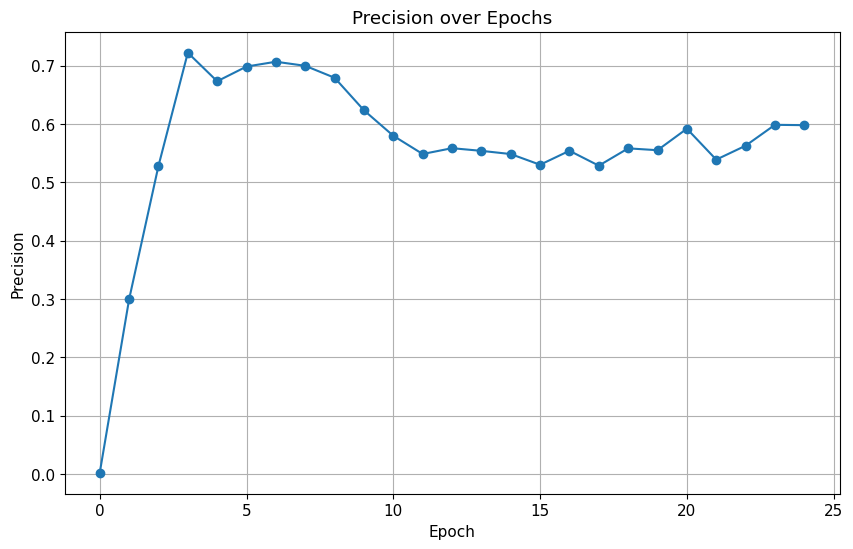

In [64]:
# Block 4: Plot Precision over Epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['epoch'], metrics_df['precision'], marker='o', linestyle='-')
plt.title('Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


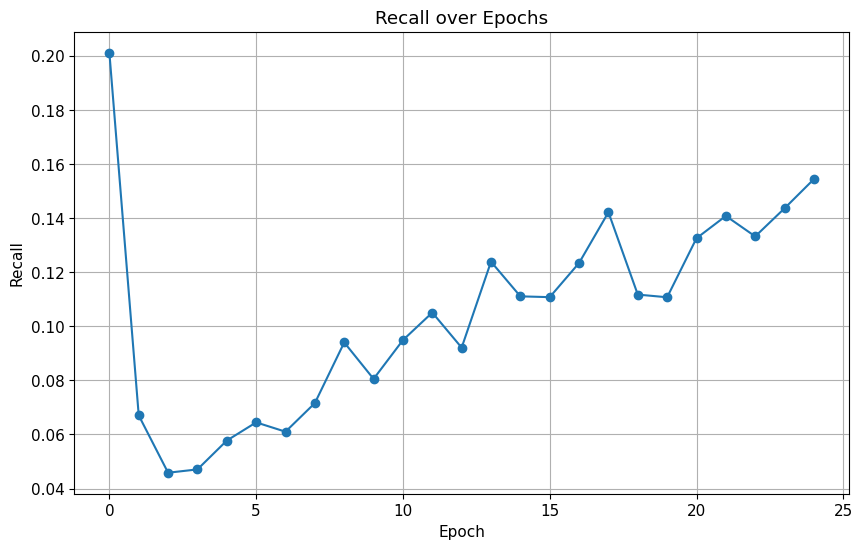

In [65]:
# Block 5: Plot Recall over Epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['epoch'], metrics_df['recall'], marker='o', linestyle='-')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)
plt.show()


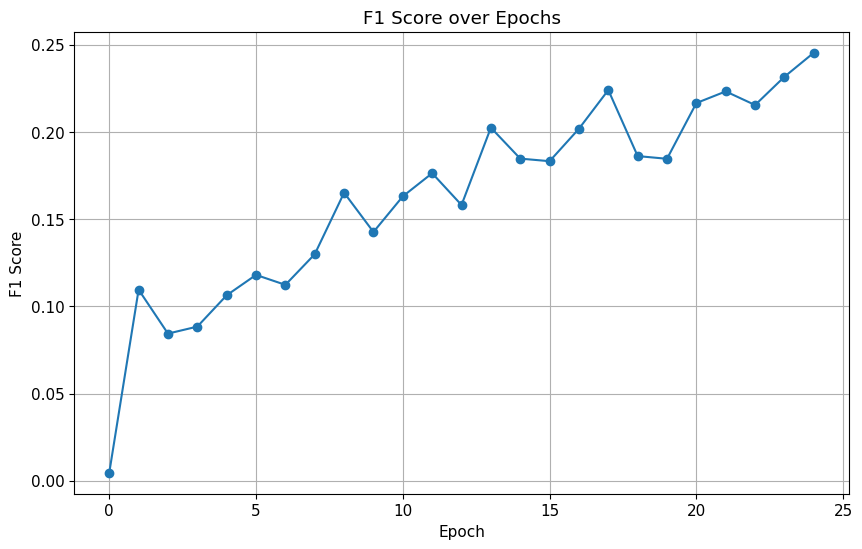

In [66]:
# Block 6: Plot F1 Score over Epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['epoch'], metrics_df['f1_score'], marker='o', linestyle='-')
plt.title('F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


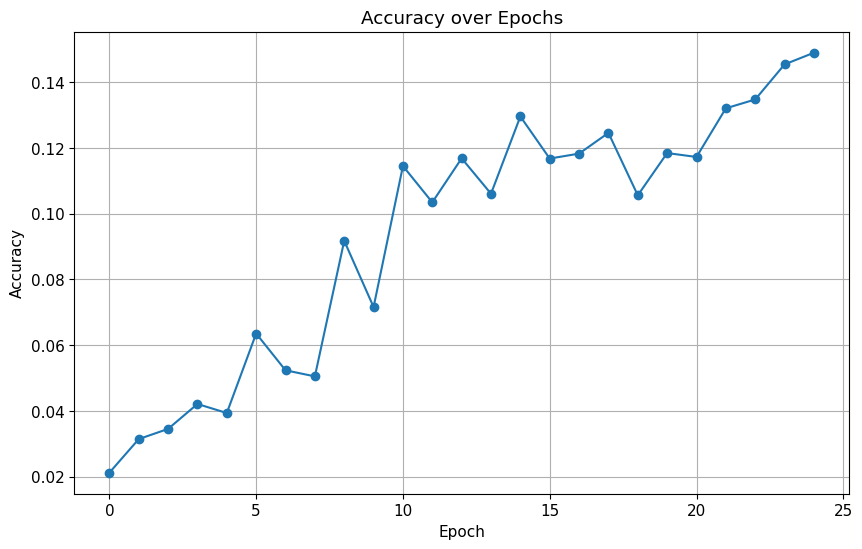

In [96]:
# Block 7: Plot Accuracy over Epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['epoch'], metrics_df['accuracy'], marker='o', linestyle='-')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


annotations unofficial

In [106]:
import os
import json

# Define the path to the annotations file
annotations_path = os.path.join('annotations_unofficial.json')

# Check if the file exists at the specified path
if not os.path.exists(annotations_path):
    print(f"File not found: {annotations_path}")
else:
    # Load annotations
    with open(annotations_path) as f:
        annotations = json.load(f)

    # Extract unique class IDs
    class_ids = set()
    invalid_annotations = []

    for annotation in annotations['annotations']:
        class_ids.add(annotation['category_id'])
        if annotation['category_id'] >= 59:
            invalid_annotations.append(annotation)
    
    # Print the number of unique classes
    print(f"Number of unique classes: {len(class_ids)}")
    print(f"Class IDs: {sorted(list(class_ids))}")

    # Check for class IDs outside the expected range
    invalid_class_ids = [class_id for class_id in class_ids if class_id >= 59]
    if invalid_class_ids:
        print(f"Invalid class IDs found: {invalid_class_ids}")
        print(f"Number of annotations with invalid class IDs: {len(invalid_annotations)}")
        print("Invalid Annotations:", invalid_annotations)
    else:
        print("All class IDs are within the expected range.")


Number of unique classes: 60
Class IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Invalid class IDs found: [59]
Number of annotations with invalid class IDs: 491
Invalid Annotations: [{'category_id': 59, 'bbox': [992.0, 684.8, 105.59999999999991, 137.60000000000002], 'segmentation': [[1027, 822, 1098, 704, 1066, 685, 992, 803]], 'area': 5360.640000000001, 'iscrowd': 0, 'id': 111, 'image_id': 56}, {'category_id': 59, 'bbox': [1955.0, 2023.7, 24.0, 18.0], 'segmentation': [[1964, 2024, 1955, 2039, 1967, 2042, 1979, 2029]], 'area': 231.0, 'iscrowd': 0, 'id': 203, 'image_id': 101}, {'category_id': 59, 'bbox': [86.0, 353.7604, 59.0, 61.00004000000001], 'segmentation': [[86, 372, 103, 394, 119, 413, 131, 415, 145, 406, 145, 391, 123, 372, 105, 354]], 'area': 1858.0013600000007, 'iscrowd': 0, 'id': 211, 'ima

In [107]:
import os
import json

# Define the path to the annotations file
annotations_path = os.path.join('annotations_unofficial.json')

# Check if the file exists at the specified path
if not os.path.exists(annotations_path):
    print(f"File not found: {annotations_path}")
else:
    # Load annotations
    with open(annotations_path) as f:
        annotations = json.load(f)

    # Filter out invalid annotations
    filtered_annotations = [annotation for annotation in annotations['annotations'] if annotation['category_id'] < 59]

    # Update the annotations
    annotations['annotations_unofficial'] = filtered_annotations

    # Save the cleaned annotations back to file
    cleaned_annotations_path = os.path.join('..', 'annotations_unofficial_cleaned.json')
    with open(cleaned_annotations_path, 'w') as f:
        json.dump(annotations, f, indent=4)
    
    print(f"Cleaned annotations saved to {cleaned_annotations_path}")

    # Verify the result
    class_ids = set()
    for annotation in annotations['annotations_unofficial']:
        class_ids.add(annotation['category_id'])
    
    print(f"Number of unique classes after cleaning: {len(class_ids)}")
    print(f"Class IDs after cleaning: {sorted(list(class_ids))}")


Cleaned annotations saved to ..\annotations_unofficial_cleaned.json
Number of unique classes after cleaning: 59
Class IDs after cleaning: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]


In [108]:
import os
import json

# Define the path to the annotations file
annotations_path = 'annotations_unofficial.json'

# Check if the file exists at the specified path
if not os.path.exists(annotations_path):
    print(f"File not found: {annotations_path}")
else:
    try:
        # Load annotations
        with open(annotations_path) as f:
            annotations = json.load(f)

        # Filter out invalid annotations
        filtered_annotations = [annotation for annotation in annotations['annotations'] if annotation['category_id'] < 59]

        # Update the annotations
        annotations['annotations_unofficial'] = filtered_annotations

        # Save the cleaned annotations back to file
        cleaned_annotations_path = os.path.join('annotations_unofficial_cleaned.json')
        with open(cleaned_annotations_path, 'w') as f:
            json.dump(annotations, f, indent=4)

        print(f"Cleaned annotations saved to {cleaned_annotations_path}")

        # Verify the result
        class_ids = {annotation['category_id'] for annotation in annotations['annotations_unofficial']}

        print(f"Number of unique classes after cleaning: {len(class_ids)}")
        print(f"Class IDs after cleaning: {sorted(class_ids)}")

    except json.JSONDecodeError:
        print("Failed to decode JSON from the file.")
    except Exception as e:
        print(f"An error occurred: {e}")


Cleaned annotations saved to annotations_unofficial_cleaned.json
Number of unique classes after cleaning: 59
Class IDs after cleaning: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]


In [109]:
import json
import shutil
import os
from sklearn.model_selection import train_test_split

%cd C:\Users\Nicho\Desktop\Thesis\yodataco

# Load both annotations
with open('yolov5/data_unofficial/annotations_unofficial.json') as f:
    annotations = json.load(f)

with open('yolov5/data_unofficial/annotations_unofficial_cleaned.json') as f:
    annotations_corrected = json.load(f)

# Merge the annotations with images
annotations['annotations'] = annotations_corrected['annotations']

# Create directories for YOLO format
os.makedirs('yolov5/data_unofficial/images/train', exist_ok=True)
os.makedirs('yolov5/data_unofficial/images/val', exist_ok=True)
os.makedirs('yolov5/data_unofficial/images/test', exist_ok=True)
os.makedirs('yolov5/data_unofficial/labels/train', exist_ok=True)
os.makedirs('yolov5/data_unofficial/labels/val', exist_ok=True)
os.makedirs('yolov5/data_unofficial/labels/test', exist_ok=True)

# Function to convert COCO to YOLO format
def convert_to_yolo(annotation):
    image_id = annotation['image_id']
    image_info = next(image for image in annotations['images'] if image['id'] == image_id)
    width, height = image_info['width'], image_info['height']
    
    x_min = annotation['bbox'][0]
    y_min = annotation['bbox'][1]
    box_width = annotation['bbox'][2]
    box_height = annotation['bbox'][3]
    
    x_center = x_min + box_width / 2
    y_center = y_min + box_height / 2
    
    x_center /= width
    y_center /= height
    box_width /= width
    box_height /= height
    
    return f"{annotation['category_id']} {x_center} {y_center} {box_width} {box_height}"

# Split data
image_ids = [img['id'] for img in annotations['images']]
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

# Get actual filenames in the directory
actual_filenames = os.listdir('yolov5/data/images/all')

# Function to find actual filename from the URL
def get_actual_filename(url):
    for filename in actual_filenames:
        if filename in url:
            return filename
    return None

# Function to save images and labels
def save_data(split, ids, base_path):
    for img_id in ids:
        image_info = next(image for image in annotations['images'] if image['id'] == img_id)
        image_filename = get_actual_filename(image_info['flickr_url'])
        
        if image_filename is None:
            print(f"Image file not found for URL: {image_info['flickr_url']}")
            continue
        
        image_path = f"yolov5/data/images/all/{image_filename}"
        target_image_path = f"{base_path}/images/{split}/{image_filename}"
        label_path = f"{base_path}/labels/{split}/{os.path.splitext(image_filename)[0]}.txt"
        
        # Copy image
        shutil.copy(image_path, target_image_path)
        
        # Save label
        labels = [convert_to_yolo(ann) for ann in annotations['annotations'] if ann['image_id'] == img_id]
        with open(label_path, 'w') as f:
            f.write('\n'.join(labels))

save_data('train', train_ids, 'yolov5/data_unofficial')
save_data('val', val_ids, 'yolov5/data_unofficial')
save_data('test', test_ids, 'yolov5/data_unofficial')


C:\Users\Nicho\Desktop\Thesis\yodataco
Image file not found for URL: https://farm66.staticflickr.com/65535/50833353463_6fbd0d01f0_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/50834137281_8355968eef_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/50833281798_ed4f5291cb_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/51620044709_52274e5c38_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/51620125060_f97ed7b5a5_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/51620119515_9b49114355_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/50834123626_30413185bb_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/50833282128_b9eea69f65_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/51619898709_28365df6c6_o.png
Image file not found for URL: https://farm66.staticflickr.com/65535/52223782422_ac3cc259

In [115]:
import json
import os
import yaml

%cd C:/Users/Nicho/Desktop/Thesis/yodataco

# Load the corrected annotations
annotations_path = os.path.join('yolov5/data_unofficial/annotations_unofficial_cleaned.json')
with open(annotations_path) as f:
    annotations = json.load(f)

# Load data_official.yaml
yaml_path = os.path.join('yolov5/data_unofficial/data_unofficial.yaml')
with open(yaml_path) as f:
    data = yaml.safe_load(f)

# Verify and clean annotations
max_valid_class_id = len(data['names']) - 1
invalid_class_ids = {ann['category_id'] for ann in annotations['annotations'] if ann['category_id'] > max_valid_class_id}

if invalid_class_ids:
    print(f"Invalid class IDs found: {invalid_class_ids}")
    cleaned_annotations = [ann for ann in annotations['annotations'] if ann['category_id'] <= max_valid_class_id]
    
    # Save cleaned annotations
    with open(annotations_path, 'w') as f:
        json.dump({'annotations': cleaned_annotations, 'categories': annotations['categories']}, f)
    print(f"Removed annotations with invalid class IDs: {invalid_class_ids}")
else:
    print("No invalid class IDs found.")

# Final verification
class_ids = {ann['category_id'] for ann in cleaned_annotations}
print(f"Number of unique classes: {len(class_ids)}")
print(f"Class IDs: {sorted(list(class_ids))}")

# Verify that the number of classes and class names match data_official.yaml
num_classes = data['nc']
class_names = data['names']

if len(class_ids) != num_classes:
    print(f"Warning: Number of unique class IDs ({len(class_ids)}) does not match number of classes in YAML ({num_classes}).")

if set(class_ids) != set(range(num_classes)):
    print(f"Warning: Class IDs in annotations do not match class IDs in YAML. Annotations: {class_ids}, YAML: {set(range(num_classes))}")

print(f"Class names in YAML: {class_names}")

# Check for any missing class IDs
missing_class_ids = set(range(num_classes)) - class_ids
if missing_class_ids:
    print(f"Missing class IDs: {missing_class_ids}")
else:
    print("No missing class IDs.")


C:\Users\Nicho\Desktop\Thesis\yodataco
No invalid class IDs found.
Number of unique classes: 58
Class IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
Class names in YAML: ['Aluminium foil', 'Battery', 'Aluminium blister pack', 'Carded blister pack', 'Other plastic bottle', 'Clear plastic bottle', 'Glass bottle', 'Plastic bottle cap', 'Metal bottle cap', 'Broken glass', 'Food Can', 'Aerosol', 'Drink can', 'Toilet tube', 'Other carton', 'Egg carton', 'Drink carton', 'Corrugated carton', 'Meal carton', 'Pizza box', 'Paper cup', 'Disposable plastic cup', 'Foam cup', 'Glass cup', 'Other plastic cup', 'Food waste', 'Glass jar', 'Plastic lid', 'Metal lid', 'Other plastic', 'Magazine paper', 'Tissues', 'Wrapping paper', 'Normal paper', 'Paper bag', 'Plastic film', 'Six pack rings', 'Garbage bag', 'Other plastic wrapp

In [119]:
import os

# Define the cache directory path
cache_dir = 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/labels'

# Remove cache files
cache_files = ['train.cache.npy', 'val.cache.npy', 'test.cache.npy']
for cache_file in cache_files:
    cache_path = os.path.join(cache_dir, cache_file)
    if os.path.exists(cache_path):
        os.remove(cache_path)
        print(f"Removed cache file: {cache_path}")
    else:
        print(f"Cache file not found: {cache_path}")


Removed cache file: C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/labels\train.cache.npy
Cache file not found: C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/labels\val.cache.npy
Cache file not found: C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/labels\test.cache.npy


In [120]:
import json
import os

# Load the cleaned annotations
annotations_path = 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/annotations_unofficial_cleaned.json'
with open(annotations_path) as f:
    annotations = json.load(f)

# Verify image-annotation pairs
image_dir = 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/images/train'
missing_images = []
for ann in annotations['annotations']:
    image_id = ann['image_id']
    image_path = os.path.join(image_dir, f"{image_id}.jpeg")  # Adjust the extension if necessary
    if not os.path.exists(image_path):
        missing_images.append(image_path)

if missing_images:
    print(f"Missing images for annotations: {missing_images}")
else:
    print("All images are present for the annotations.")


Missing images for annotations: ['C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/images/train\\0.jpeg', 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/images/train\\1.jpeg', 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/images/train\\2.jpeg', 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/images/train\\3.jpeg', 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/images/train\\4.jpeg', 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/images/train\\4.jpeg', 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/images/train\\5.jpeg', 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/images/train\\5.jpeg', 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/images/train\\5.jpeg', 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/images/train\\6.jpeg', 'C:/Users/Nicho/Desktop/Thesis/yodataco/yolov5/data_unofficial/images/train\\7.jpeg', 'C:/Users/Nicho/Deskt

In [138]:
import os

# Directories containing the label files
train_labels_dir = r'C:\Users\Nicho\Desktop\Thesis\yodataco\yolov5\data_unofficial\labels\train'
val_labels_dir = r'C:\Users\Nicho\Desktop\Thesis\yodataco\yolov5\data_unofficial\labels\val'
# List of invalid category IDs
invalid_category_ids = [58, 59]

# Function to remove invalid annotations from label files
def remove_invalid_labels(labels_dir, invalid_category_ids):
    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as file:
            lines = file.readlines()
        
        valid_lines = [
            line for line in lines
            if int(line.split()[0]) not in invalid_category_ids
        ]
        
        with open(label_path, 'w') as file:
            file.writelines(valid_lines)

# Remove invalid annotations from training and validation sets
remove_invalid_labels(train_labels_dir, invalid_category_ids)
remove_invalid_labels(val_labels_dir, invalid_category_ids)

print("Invalid annotations have been removed from label files successfully.")

# Function to re-check labels in the dataset
def check_labels(labels_dir, invalid_category_ids):
    invalid_labels = []
    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                category_id = int(line.split()[0])
                if category_id in invalid_category_ids:
                    invalid_labels.append((label_file, line))
    return invalid_labels

# Check for invalid labels again in training and validation sets
invalid_train_labels = check_labels(train_labels_dir, invalid_category_ids)
invalid_val_labels = check_labels(val_labels_dir, invalid_category_ids)

if invalid_train_labels:
    print("Found invalid labels in the following training files after cleanup:")
    for label_file, label in invalid_train_labels:
        print(f"{label_file}: {label.strip()}")
else:
    print("No invalid labels found in the training labels directory after cleanup.")

if invalid_val_labels:
    print("Found invalid labels in the following validation files after cleanup:")
    for label_file, label in invalid_val_labels:
        print(f"{label_file}: {label.strip()}")
else:
    print("No invalid labels found in the validation labels directory after cleanup.")


Invalid annotations have been removed from label files successfully.
No invalid labels found in the training labels directory after cleanup.
No invalid labels found in the validation labels directory after cleanup.


In [144]:
# Block 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Ensure inline plotting in Jupyter notebooks
%matplotlib inline

# Block 2: Load Data
results = pd.read_csv(r'C:\Users\Nicho\Desktop\Thesis\yodataco\yolov5\runs\train\unofficial_yolo6\results.csv')

# Clean column names to remove leading and trailing spaces
results.columns = results.columns.str.strip()

# Display first few rows of the dataframe
print(results.head())

# Display the columns of the dataframe
print(results.columns)

   epoch  train/box_loss  train/obj_loss  train/cls_loss  metrics/precision  \
0      0        0.098032        0.030124        0.098807           0.002586   
1      1        0.067551        0.027396        0.090645           0.659650   
2      2        0.063200        0.024706        0.086849           0.814090   
3      3        0.059744        0.024504        0.085309           0.607080   
4      4        0.055784        0.023857        0.084062           0.584420   

   ...  val/obj_loss  val/cls_loss     x/lr0     x/lr1     x/lr2  
0  ...      0.021729      0.094494  0.070213  0.003310  0.003310  
1  ...      0.017900      0.087868  0.039950  0.006380  0.006380  
2  ...      0.017557      0.085641  0.009423  0.009186  0.009186  
3  ...      0.018233      0.084441  0.008812  0.008812  0.008812  
4  ...      0.017605      0.083752  0.008812  0.008812  0.008812  

[5 rows x 14 columns]
Index(['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss',
       'metrics/precision', 'm

In [145]:
# Block 3: Compute Metrics
# Use the correct column names based on the provided DataFrame structure
def compute_metrics(df):
    df['precision'] = df['metrics/precision']
    df['recall'] = df['metrics/recall']
    df['f1_score'] = 2 * (df['precision'] * df['recall']) / (df['precision'] + df['recall'])
    df['accuracy'] = df['metrics/mAP_0.5']  # mAP_0.5 as a proxy for accuracy in this context
    return df

metrics_df = compute_metrics(results)

# Display first few rows of the dataframe with metrics
print(metrics_df.head())

   epoch  train/box_loss  train/obj_loss  train/cls_loss  metrics/precision  \
0      0        0.098032        0.030124        0.098807           0.002586   
1      1        0.067551        0.027396        0.090645           0.659650   
2      2        0.063200        0.024706        0.086849           0.814090   
3      3        0.059744        0.024504        0.085309           0.607080   
4      4        0.055784        0.023857        0.084062           0.584420   

   ...     x/lr2  precision    recall  f1_score  accuracy  
0  ...  0.003310   0.002586  0.329080  0.005132  0.007955  
1  ...  0.006380   0.659650  0.031277  0.059722  0.013999  
2  ...  0.009186   0.814090  0.018056  0.035328  0.015718  
3  ...  0.008812   0.607080  0.068171  0.122577  0.018366  
4  ...  0.008812   0.584420  0.064727  0.116546  0.018478  

[5 rows x 18 columns]


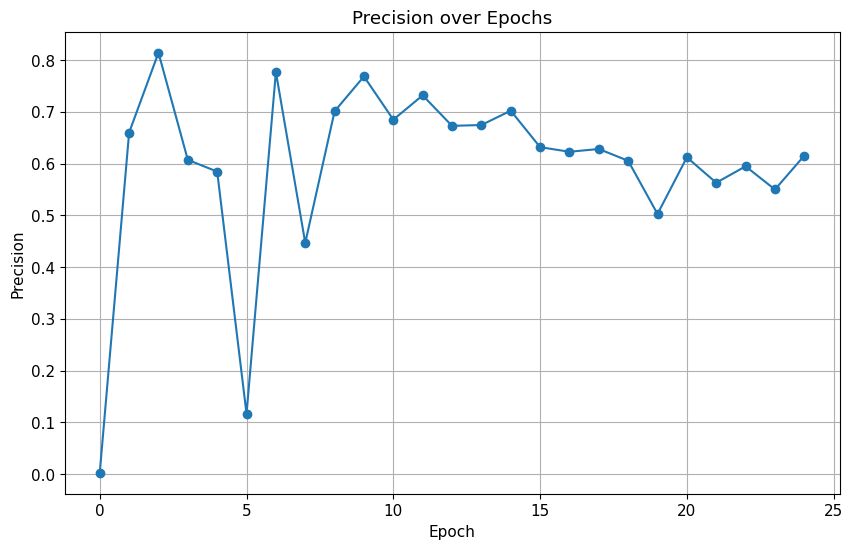

In [146]:
# Block 4: Plot Precision over Epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['epoch'], metrics_df['precision'], marker='o', linestyle='-')
plt.title('Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

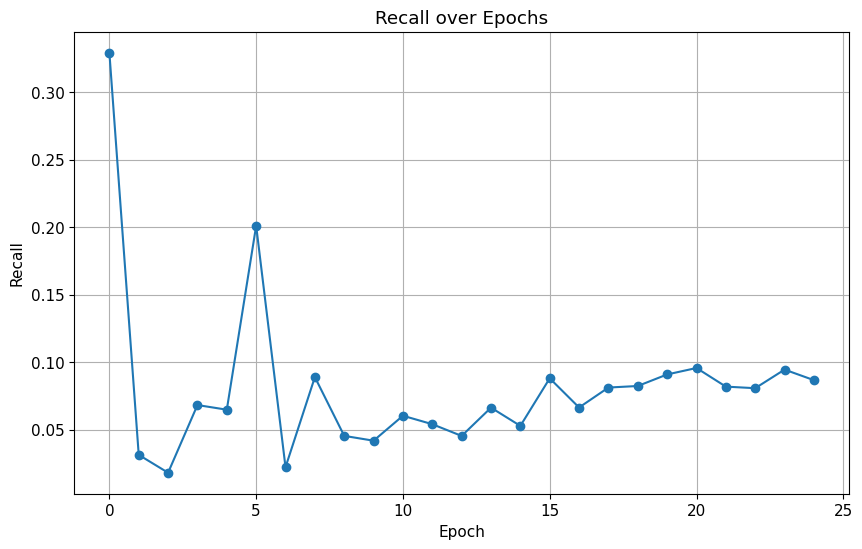

In [147]:
# Block 5: Plot Recall over Epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['epoch'], metrics_df['recall'], marker='o', linestyle='-')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)
plt.show()


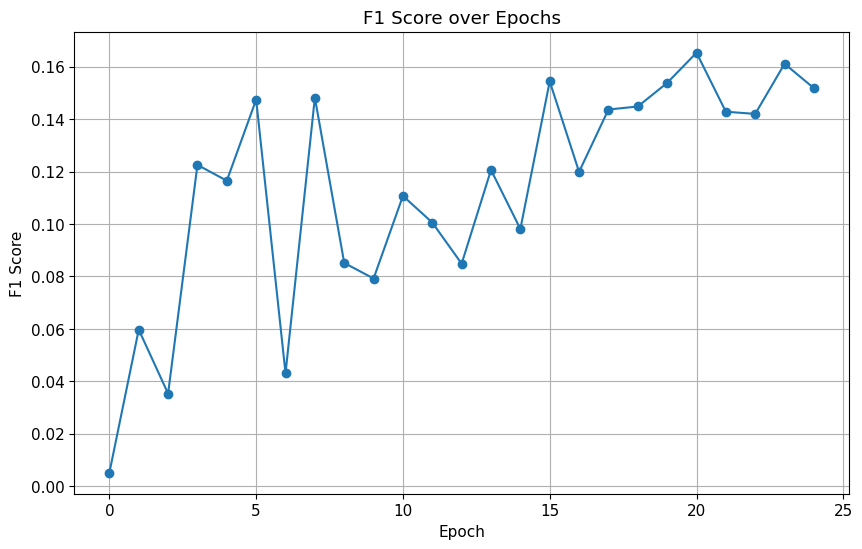

In [148]:
# Block 6: Plot F1 Score over Epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['epoch'], metrics_df['f1_score'], marker='o', linestyle='-')
plt.title('F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

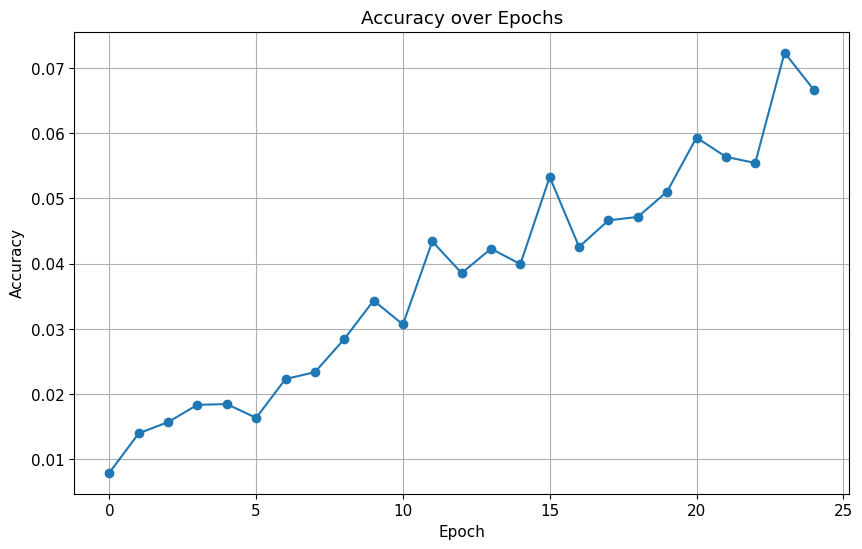

In [149]:
# Block 7: Plot Accuracy over Epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['epoch'], metrics_df['accuracy'], marker='o', linestyle='-')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
